# Group 8 Home Default Project

<!-- Table of Contents -->
<div id="toc_container">
    <p class="toc_title">Table of Contents</p>
    <ul class="toc_list">
        <li><a href="#section-1">1 Introduction</a></li>
        <li><a href="#section-2">2 Data Preparation</a>
            <ul>
                <li><a href="#section-2.1">2.1 Import Libraries</a></li>
                <li><a href="#section-2.2">2.2 Read in Data</a></li>
                <li><a href="#section-2.3">2.3 Data Distributions</a></li>
                <li><a href="#section-2.4">2.4 Reference Data Types</a></li>
                <li><a href="#section-2.5">2.5 Correlations</a></li>
                <li><a href="#section-2.6">2.6 Combine Train and Test</a></li>
                <li><a href="#section-2.7">2.7 Display Numeric NA's</a></li>
                <li><a href="#section-2.8">2.8 Converting Numeric NA's to Median</a></li>
                <li><a href="#section-2.9">2.9 Remaining Missing Data</a></li>
                <li><a href="#section-2.10">2.10 Categorical Missing Data</a></li>
                <li><a href="#section-2.11">2.11 Convert Test Back to Dataframe</a></li>
                <li><a href="#section-2.12">2.12 Merge Train and Application</a></li>
                <li><a href="#section-2.13">2.13 Remove NA's Post-Join</a></li>
                <li><a href="#section-2.14">2.14 Downsampling</a></li>
                <li><a href="#section-2.15">2.15 Remove Remaining Excess Columns</a></li>
            </ul>
        </li>
        <li><a href="#section-3">3 Modeling Process</a>
            <ul>
                <li><a href="#section-3.1">3.1 Data Partition</a></li>
                <li><a href="#section-3.2">3.2 Linear Regression</a></li>
                <li><a href="#section-3.3">3.3 Random Forest & Gradient Boosting</a></li>
            </ul>
        </li>
        <li><a href="#section-4">4 Model Performance</a>
            <ul>
                <li><a href="#section-4.1">4.1 Testing Against Real Data</a></li>
                <li><a href="#section-4.2">4.2 Gradient Boosting Interpretation</a></li>
            </ul>
        </li>
        <li><a href="#section-5">5 Results</a></li>
    </ul>
</div>


# 1 Introduction
<a id="section-1"></a>

The purpose of this project is to identify how capable an applicant is to repay a loan. Rather than simply look at credit as a predictor, Home Credit Group is striving to identify reliable borrowers with limited or no credit history. Through classification modeling techniques, we identified factors that contribute to whether an application for a loan should be approved or not.

# 2 Data Preparation
<a id="section-2"></a>

## 2.1 Import Libraries
<a id="section-2.1"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from sklearn.utils import resample

## 2.2 Read in Data
<a id="section-2.2"></a>

In [2]:
previous =  'https://storage.googleapis.com/home_credit_files/previous_application.csv'
train_main = 'https://storage.googleapis.com/home_credit_files/application_train.csv'
test_main =  'https://storage.googleapis.com/home_credit_files/application_test.csv'

chunk_size = 25000

# Initialize empty list to store chunks
chunks_train = []
chunks_test = []
chunks_previous = []

# Read train data in chunks
for train_chunk in pd.read_csv(train_main, index_col=False, chunksize=chunk_size, low_memory=False,nrows=100000):
    # Process train_chunk here (e.g., clean, transform, analyze)
    chunks_train.append(train_chunk)

# Concatenate train chunks to create final DataFrame
df_t = pd.concat(chunks_train, ignore_index=True)

# Read test data in chunks
for test_chunk in pd.read_csv(test_main, index_col=False, chunksize=chunk_size, low_memory=False):
    # Process test_chunk here (e.g., clean, transform, analyze)
    chunks_test.append(test_chunk)

# Concatenate test chunks to create final DataFrame
df_e = pd.concat(chunks_test, ignore_index=True)

# Read previous data in chunks
for prev_chunk in pd.read_csv(previous, index_col=False, chunksize=chunk_size, low_memory=False,nrows=100000):
    # Process prev_chunk here (e.g., clean, transform, analyze)
    chunks_previous.append(prev_chunk)

# Concatenate previous chunks to create final DataFrame
previous_app_df = pd.concat(chunks_previous, ignore_index=True)

Working with the size of our dataset we read the data in by chunks of 25,000 rows at a time. We then concatenated the chunks to create the final dataframe.

## 2.3 Data Distributions
<a id="section-2.3"></a>

In [3]:
# Ratio of Male to Females
gender_counts = df_t['CODE_GENDER'].value_counts()
male_percentage = (gender_counts['M'] / df_t.shape[0]) * 100
female_percentage = (gender_counts['F'] / df_t.shape[0]) * 100
print(male_percentage)
print(female_percentage)

35.480000000000004
64.519


We thought it was interesting that 65% of the train set was female.

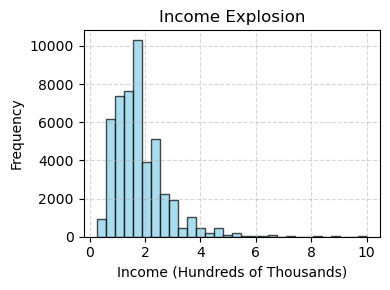

In [4]:
# Graph of Income Distribution
# Clean NA values in the "AMT_INCOME_TOTAL" column
df_cleaned = df_e.dropna(subset=['AMT_INCOME_TOTAL'])

# Convert the "AMT_INCOME_TOTAL" column to numeric
df_cleaned['AMT_INCOME_TOTAL'] = pd.to_numeric(df_cleaned['AMT_INCOME_TOTAL'], errors='coerce')

# Cap the income at 1 million
df_cleaned['AMT_INCOME_TOTAL'] = df_cleaned['AMT_INCOME_TOTAL'].clip(upper=1000000)

# Convert income to hundreds of thousands for the x-axis
df_cleaned['AMT_INCOME_TOTAL_hundreds_thousands'] = df_cleaned['AMT_INCOME_TOTAL'] / 100000

# Plot a histogram
plt.figure(figsize=(4, 3))
plt.hist(df_cleaned['AMT_INCOME_TOTAL_hundreds_thousands'], bins=30, color='skyblue', edgecolor='black', alpha=0.7)
plt.title('Income Explosion')
plt.xlabel('Income (Hundreds of Thousands)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()


We thought it was interesting seeing the breakdown of income across the train set.

## 2.4 Reference Data Types
<a id="section-2.4"></a>

In [5]:
pd.set_option('display.max_rows', None)
data_types = df_t.dtypes
print(data_types)

SK_ID_CURR                        int64
TARGET                            int64
NAME_CONTRACT_TYPE               object
CODE_GENDER                      object
FLAG_OWN_CAR                       bool
FLAG_OWN_REALTY                    bool
CNT_CHILDREN                      int64
AMT_INCOME_TOTAL                float64
AMT_CREDIT                      float64
AMT_ANNUITY                     float64
AMT_GOODS_PRICE                 float64
NAME_TYPE_SUITE                  object
NAME_INCOME_TYPE                 object
NAME_EDUCATION_TYPE              object
NAME_FAMILY_STATUS               object
NAME_HOUSING_TYPE                object
REGION_POPULATION_RELATIVE      float64
DAYS_BIRTH                        int64
DAYS_EMPLOYED                     int64
DAYS_REGISTRATION                 int64
DAYS_ID_PUBLISH                   int64
OWN_CAR_AGE                     float64
FLAG_MOBIL                        int64
FLAG_EMP_PHONE                    int64
FLAG_WORK_PHONE                   int64


In [6]:
df_e.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 48744 entries, 0 to 48743
Columns: 121 entries, SK_ID_CURR to AMT_REQ_CREDIT_BUREAU_YEAR
dtypes: float64(65), int64(40), object(16)
memory usage: 45.0+ MB


Here we can see information on the dataset. Above is the data types for each row in the dataframe as well as the breakdown of how many are in each data type.

## 2.5 Correlations
<a id="section-2.5"></a>

In [7]:
# Filter out object type columns from the DataFrame
numeric_df = df_t.select_dtypes(include=['int64', 'float64'])

# Compute correlations with the TARGET column
correlations = numeric_df.corr()['TARGET'].sort_values(ascending=False)

# Select the top 30 positive correlations
top_positive_correlations = correlations.head(30)

# Select the top 30 negative correlations
top_negative_correlations = correlations.tail(30)

# Display the results
print("Top 30 positive correlations:")
print(top_positive_correlations)
print("\nTop 30 negative correlations:")
print(top_negative_correlations)

Top 30 positive correlations:
TARGET                         1.000000
DAYS_BIRTH                     0.085606
DAYS_LAST_PHONE_CHANGE         0.064829
REGION_RATING_CLIENT_W_CITY    0.061884
REGION_RATING_CLIENT           0.061581
FLAG_EMP_PHONE                 0.053128
DAYS_ID_PUBLISH                0.052184
REG_CITY_NOT_WORK_CITY         0.049873
REG_CITY_NOT_LIVE_CITY         0.049431
FLAG_DOCUMENT_3                0.046787
DAYS_REGISTRATION              0.044409
NONLIVINGAREA_MODE             0.039588
NONLIVINGAREA_MEDI             0.036809
NONLIVINGAREA_AVG              0.036423
DEF_30_CNT_SOCIAL_CIRCLE       0.034605
OWN_CAR_AGE                    0.032658
DEF_60_CNT_SOCIAL_CIRCLE       0.032143
FLAG_WORK_PHONE                0.026592
LIVE_CITY_NOT_WORK_CITY        0.025545
AMT_REQ_CREDIT_BUREAU_YEAR     0.024406
CNT_CHILDREN                   0.021518
FLAG_DOCUMENT_2                0.010917
CNT_FAM_MEMBERS                0.008742
REG_REGION_NOT_LIVE_REGION     0.008591
FLAG_CONT_

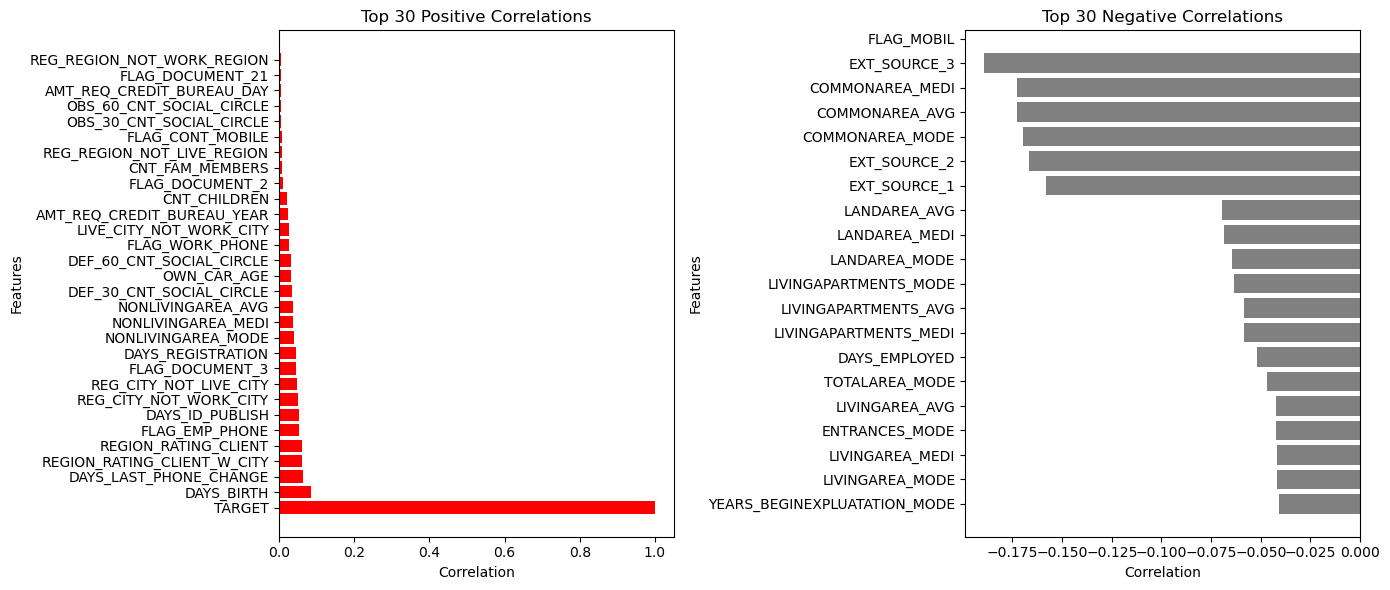

In [8]:
# Set up subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Plot top 30 positive correlations
axes[0].barh(top_positive_correlations.index, top_positive_correlations.values, color='red')
axes[0].set_title('Top 30 Positive Correlations')
axes[0].set_xlabel('Correlation')
axes[0].set_ylabel('Features')

# Plot top 30 negative correlations
axes[1].barh(top_negative_correlations.index, top_negative_correlations.values, color='gray')
axes[1].set_title('Top 30 Negative Correlations')
axes[1].set_xlabel('Correlation')
axes[1].set_ylabel('Features')

# Adjust layout
plt.tight_layout()

# Show plot
plt.show()


Our first method to discovering if there is any obvious correlations in the dataset was to produce an output displaying the top  positive and negative correlations in the dataframe. With no single variable standing out we will move forward with modeling later in the notebook

In [9]:
df_t.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,...,FLAG_DOCUMENT_18,FLAG_DOCUMENT_19,FLAG_DOCUMENT_20,FLAG_DOCUMENT_21,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR
0,278284,0,Cash loans,F,False,True,0,90000.0,360000.0,13059.0,...,0,0,0,0,0.0,0.0,0.0,0.0,2.0,1.0
1,278285,0,Cash loans,F,False,True,0,135000.0,728460.0,57685.5,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,2.0
2,278289,0,Revolving loans,M,False,True,0,225000.0,180000.0,9000.0,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
3,278290,0,Cash loans,F,False,False,1,72000.0,675000.0,21775.5,...,0,0,0,0,0.0,0.0,0.0,0.0,0.0,1.0
4,278292,0,Cash loans,M,True,False,0,157500.0,545040.0,25407.0,...,0,0,0,0,0.0,0.0,0.0,0.0,1.0,1.0


## 2.6 Combine Train and Test
<a id="section-2.6"></a>

In [10]:
# Add a new column to indicate the source dataset
df_t['is_test'] = 0  # For train data, set to 0
df_e['is_test'] = 1   # For test data, set to 1

# Concatenate the train and test datasets
df_combined = pd.concat([df_t, df_e], ignore_index=True)

Categorical Data to be converted next. Take a look at any float or object data with less than 25 unique values and convert to category
* Except target
* Gender -> Category
* Name Contract type -> Category

In [11]:
# Categorizing the variables
for col in df_combined.columns:
    if df_combined[col].dtype == 'object' and df_combined[col].nunique() < 25:
        df_combined[col] = df_combined[col].astype('category')

Here we combined train and test to perform our ETA on both sets simultaneously. All columns with less then 25 unique variables were converted into categorical variables.

## 2.7 Display Numeric NA's
<a id="section-2.7"></a>

In [12]:
# Display numeric NA's
all_Xdata_na = (df_combined.isnull().sum() / len(df_combined)) * 100
all_Xdata_na = all_Xdata_na.drop(all_Xdata_na[all_Xdata_na == 0].index).sort_values(ascending=False)[:300]
missing_data = pd.DataFrame({'Missing Data Percent' :all_Xdata_na})

In [13]:
pd.set_option('display.max_rows', None)
missing_data

,Missing Data Percent
COMMONAREA_MODE,89.725972
COMMONAREA_MEDI,89.725972
COMMONAREA_AVG,89.725972
NONLIVINGAPARTMENTS_MEDI,89.640591
NONLIVINGAPARTMENTS_AVG,89.640591
NONLIVINGAPARTMENTS_MODE,89.640591
LIVINGAPARTMENTS_AVG,89.215699
LIVINGAPARTMENTS_MEDI,89.215699
LIVINGAPARTMENTS_MODE,89.215699
FONDKAPREMONT_MODE,89.211666


<Figure size 1000x800 with 0 Axes>

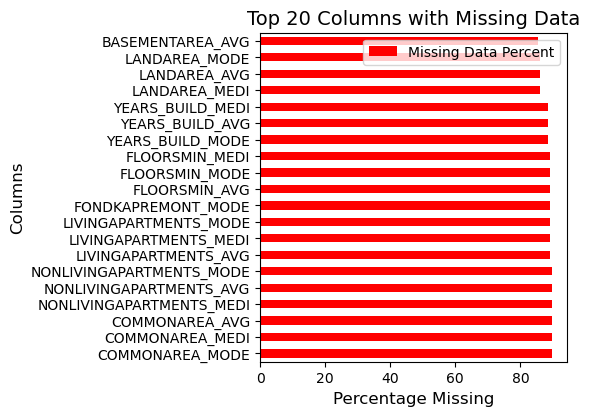

In [14]:
# Graph of top 10 missing data columns

# Selecting only the top 20 rows
top_20_missing_data = missing_data.head(20)

# Increase the figure size to accommodate more space for labels
plt.figure(figsize=(10, 8))

# Plotting
top_20_missing_data.plot(kind='barh', color='red')  # Horizontal bar plot

# Add title and labels with smaller font size
plt.title('Top 20 Columns with Missing Data', fontsize=14)
plt.xlabel('Percentage Missing', fontsize=12)
plt.ylabel('Columns', fontsize=12)

# Decrease the font size of the ticks
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)

# Add more space between bars
plt.tight_layout(pad=3.0)

plt.show()

Next, we wanted to view the percentage of values missing in each column of data. This showed us that a large amount of columns were missing over half of their values.

## 2.8 Converting Numeric NA's to Median
<a id="section-2.8"></a>

In [15]:
for col in df_combined.columns:
    # Check if the column is of float64 data type and has missing or NA values
    if df_combined[col].dtype == 'float64' and df_combined[col].isnull().any():
        # Calculate the median of the column
        median_value = df_combined[col].median()
        # Fill missing values with the median
        df_combined[col].fillna(median_value, inplace=True)

To resolve the missing data in these rows, we converted the null values to the median of the dataset. This allows the column to still be usable without swaying our data in an unfavorable way.

## 2.9 Remaining Missing Data
<a id="section-2.9"></a>

In [16]:
columns_with_missing_data = df_combined.columns[df_combined.isnull().any()].tolist()

# Display the columns with missing data
print(columns_with_missing_data)

['NAME_TYPE_SUITE', 'OCCUPATION_TYPE', 'FONDKAPREMONT_MODE', 'HOUSETYPE_MODE', 'WALLSMATERIAL_MODE', 'EMERGENCYSTATE_MODE']


We have just 6 remaining columns with missing data.

## 2.10 Categorical Missing Data
<a id="section-2.10"></a>

In [17]:
df_na_columns = df_combined[columns_with_missing_data]

# Show the head of the DataFrame
df_na_columns.head()

,NAME_TYPE_SUITE,OCCUPATION_TYPE,FONDKAPREMONT_MODE,HOUSETYPE_MODE,WALLSMATERIAL_MODE,EMERGENCYSTATE_MODE
0,Unaccompanied,NaN,NaN,NaN,NaN,NaN
1,Unaccompanied,Core staff,NaN,NaN,NaN,NaN
2,Unaccompanied,Drivers,NaN,NaN,NaN,NaN
3,Unaccompanied,Sales staff,NaN,NaN,NaN,NaN
4,Unaccompanied,NaN,NaN,NaN,NaN,NaN


In [18]:
pd.set_option('display.max_rows', None)
missing_percentages = (df_na_columns.isna().sum() / len(df_na_columns)) * 100
print(missing_percentages)

NAME_TYPE_SUITE         0.873985
OCCUPATION_TYPE        31.499758
FONDKAPREMONT_MODE     89.211666
HOUSETYPE_MODE         81.780105
WALLSMATERIAL_MODE     82.061125
EMERGENCYSTATE_MODE    77.987011
dtype: float64


In [19]:
for col in df_combined.columns:
    # Check if the column is of object data type and has missing or NA values
    if df_combined[col].dtype == 'object' and df_combined[col].isnull().any():
        # Calculate the mode of the column
        mode_values = df_combined[col].mode().iloc[0]
        # Fill missing values with the mode
        df_combined[col].fillna(mode_values, inplace=True)

For the remaining categorical columns with missing data, we computed the mode value and inputted it in place of the nulls, removing the last of the NA's in our dataset.

## 2.11 Convert Test Back to Dataframe
<a id="section-2.11"></a>

In [20]:
df_e = df_combined[df_combined['is_test'] == 1]

# Remove the 'is_test' column from the combined DataFrame
df_combined.drop(columns=['is_test'], inplace=True)
df_e.drop(columns=['is_test'], inplace=True)

len(df_e)

C:\Users\hunte\AppData\Local\Temp\ipykernel_9528\3917646989.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_e.drop(columns=['is_test'], inplace=True)


48744

In [21]:
df_t = df_combined.copy()

Now that the data transformation is complete. We spliced the test data back into its own dataframe so that it can be used to produce our Kaggle results later. 

## 2.12 Merge Train and Application
<a id="section-2.12"></a>

In [22]:
# previous_app_df = pd.read_csv(f'previous_application.csv', index_col=False, low_memory=False)
original_id = df_e['SK_ID_CURR'].tolist()
previous_app_df.drop_duplicates(subset='SK_ID_CURR', inplace=True)

df_merged = pd.merge(df_t, previous_app_df, on="SK_ID_CURR", how="left")

# Drop previous DUPLICATES
df_e = pd.merge(df_e, previous_app_df, on="SK_ID_CURR", how="left")

In [23]:
categorical_vars = df_merged.select_dtypes(include=['object','category']).columns.tolist()
test_categorical_vars = df_e.select_dtypes(include=['object','category']).columns.tolist()

# Perform one-hot encoding on the identified categorical variables
df_encoded = pd.get_dummies(df_merged, columns=categorical_vars)
df_e_encoded = pd.get_dummies(df_e, columns=test_categorical_vars)

# Optionally, if you want to limit one-hot encoding to specific columns, you can replace 'categorical_vars' with a subset of column names
# Example: df_encoded = pd.get_dummies(df, columns=['NAME_CONTRACT_TYPE_x', 'CODE_GENDER'])

# Check the shape of the original and encoded dataframe to understand the transformation
print("Original shape:", df_merged.shape)
print("Encoded shape:", df_encoded.shape)
print("Test Encoded shape:", df_e_encoded.shape)

# Display the first few rows of the encoded dataframe
#print(df_encoded.head())
#print(categorical_vars)

Original shape: (148744, 158)
Encoded shape: (148744, 410)
Test Encoded shape: (48744, 408)


Next, we wanted to merge the previous_applications set with our train set to bring in more values that may affect our modeling.

## 2.13 Remove NA's Post-Join
<a id="section-2.13"></a>

In [24]:
# Clean New Joined Dataset
all_Xdata_na = (df_encoded.isnull().sum() / len(df_combined)) #* 100
all_Xdata_na = all_Xdata_na.drop(all_Xdata_na[all_Xdata_na == 0].index).sort_values(ascending=False)[:300]
missing_data = pd.DataFrame({'Missing Data Percent' :all_Xdata_na})

all_test_na = (df_e_encoded.isnull().sum() / len(df_e)) #* 100
all_test_na = all_test_na.drop(all_test_na[all_test_na == 0].index).sort_values(ascending=False)[:300]
test_missing = pd.DataFrame({'Missing Data Percent' :all_test_na})



In [25]:
pd.set_option('display.max_rows', None)
missing_data

,Missing Data Percent
RATE_INTEREST_PRIVILEGED,0.999086
RATE_INTEREST_PRIMARY,0.999086
AMT_DOWN_PAYMENT,0.880560
RATE_DOWN_PAYMENT,0.880560
DAYS_TERMINATION,0.851913
DAYS_LAST_DUE,0.851913
DAYS_LAST_DUE_1ST_VERSION,0.851913
DAYS_FIRST_DUE,0.851913
DAYS_FIRST_DRAWING,0.851913
NFLAG_INSURED_ON_APPROVAL,0.851913


In [26]:
pd.set_option('display.max_rows', None)
test_missing

,Missing Data Percent
RATE_INTEREST_PRIVILEGED,0.998790
RATE_INTEREST_PRIMARY,0.998790
AMT_DOWN_PAYMENT,0.881011
RATE_DOWN_PAYMENT,0.881011
DAYS_TERMINATION,0.849212
DAYS_LAST_DUE,0.849212
DAYS_LAST_DUE_1ST_VERSION,0.849212
DAYS_FIRST_DUE,0.849212
DAYS_FIRST_DRAWING,0.849212
NFLAG_INSURED_ON_APPROVAL,0.849212


In [27]:
for col in df_encoded.columns:
    # Check if the column is of float64 data type and has missing or NA values
    if df_encoded[col].dtype == 'float64' and df_encoded[col].isnull().any():
        # Calculate the median of the column
        median_value = df_encoded[col].median()
        # Fill missing values with the median
        df_encoded[col].fillna(median_value, inplace=True)

# Test
for col in df_e_encoded.columns:
    # Check if the column is of float64 data type and has missing or NA values
    if df_e_encoded[col].dtype == 'float64' and df_e_encoded[col].isnull().any():
        # Calculate the median of the column
        median_value = df_e_encoded[col].median()
        # Fill missing values with the median
        df_e_encoded[col].fillna(median_value, inplace=True) 
        
df_e_encoded.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,100001,0.0,0,135000.0,568800.0,20560.5,450000.0,0.018850,-19241,-2329,...,False,False,False,False,False,False,False,False,False,False
1,100005,0.0,0,99000.0,222768.0,17370.0,180000.0,0.035792,-18064,-4469,...,False,False,False,False,False,False,False,False,False,False
2,100013,0.0,0,202500.0,663264.0,69777.0,630000.0,0.019101,-20038,-4458,...,False,False,False,False,False,False,True,False,False,False
3,100028,0.0,2,315000.0,1575000.0,49018.5,1575000.0,0.026392,-13976,-1866,...,False,False,False,False,False,False,False,False,False,False
4,100038,0.0,1,180000.0,625500.0,32067.0,625500.0,0.010032,-13040,-2191,...,False,False,False,False,False,False,False,False,False,False


In [28]:
pd.set_option('display.max_rows', None)
df_encoded.head()

,SK_ID_CURR,TARGET,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT_x,AMT_ANNUITY_x,AMT_GOODS_PRICE_x,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,...,PRODUCT_COMBINATION_Cash X-Sell: low,PRODUCT_COMBINATION_Cash X-Sell: middle,PRODUCT_COMBINATION_POS household with interest,PRODUCT_COMBINATION_POS household without interest,PRODUCT_COMBINATION_POS industry with interest,PRODUCT_COMBINATION_POS industry without interest,PRODUCT_COMBINATION_POS mobile with interest,PRODUCT_COMBINATION_POS mobile without interest,PRODUCT_COMBINATION_POS other with interest,PRODUCT_COMBINATION_POS others without interest
0,278284,0.0,0,90000.0,360000.0,13059.0,360000.0,0.014520,-21950,365243,...,False,False,False,False,False,False,False,False,False,False
1,278285,0.0,0,135000.0,728460.0,57685.5,675000.0,0.015221,-15645,-8615,...,False,False,False,False,False,False,False,False,False,False
2,278289,0.0,0,225000.0,180000.0,9000.0,180000.0,0.025164,-11926,-1049,...,False,False,False,False,False,False,False,False,False,False
3,278290,0.0,1,72000.0,675000.0,21775.5,675000.0,0.019101,-15597,-795,...,False,False,False,False,False,False,False,False,False,False
4,278292,0.0,0,157500.0,545040.0,25407.0,450000.0,0.006629,-13220,-1769,...,False,False,False,False,False,False,False,False,False,False


Upon bringing in the previous application set. We needed to perform further data cleaning similar to what we did with our train and test set. Our data is near ready for modeling.

## 2.14 Downsampling
<a id="section-2.14"></a>

In [29]:
# Separate majority and minority classes
majority_class = df_encoded[df_encoded['TARGET'] == 0]
minority_class = df_encoded[df_encoded['TARGET'] == 1]

# Downsample majority class
desired_ratio = 9  # Desired ratio for majority to minority class
downsampled_majority = resample(majority_class, 
                                replace=False,  # Sample without replacement to avoid duplication
                                n_samples=int(len(minority_class) / desired_ratio),  # Downsample to match desired ratio
                                random_state=113)  # Set random state for reproducibility

# Combine minority class with downsampled majority class
df_downsampled = pd.concat([downsampled_majority, minority_class])

# Shuffle the DataFrame to mix up the order of the rows
df_downsampled = df_downsampled.sample(frac=1, random_state=113).reset_index(drop=True)


With our majority class having such a large imbalance over the minority class we wanted to downsample it to balance them out. We then combined the downsampled majority class with the minority class and shuffled it to give us our downsampled dataframe.

## 2.15 Remove Remaining Excess Columns
<a id="section-2.15"></a>

In [30]:
columns_merged = df_downsampled.columns
columns_e = df_e_encoded.columns

# Find the columns that are in df_merged but not in df_e
columns_diff_merged = set(columns_merged) - set(columns_e)

# Find the columns that are in df_e but not in df_merged
columns_diff_e = set(columns_e) - set(columns_merged)

# Print the different columns
print("Columns in df_merged but not in df_e:", columns_diff_merged)
print("Columns in df_e but not in df_merged:", columns_diff_e)

df_downsampled.drop(columns=['NAME_GOODS_CATEGORY_Weapon','NAME_GOODS_CATEGORY_Additional Service'], inplace=True)

Columns in df_merged but not in df_e: {'NAME_GOODS_CATEGORY_Weapon', 'NAME_GOODS_CATEGORY_Additional Service'}
Columns in df_e but not in df_merged: set()


Finally, we removed our excess rows and the data is now read for modeling.

# 3 Modeling Process
<a id="section-3"></a>

## 3.1 Data Partition
<a id="section-3.1"></a>

In [31]:
# Define your features (X) and target variable (y) based on your EDA
X_train = df_downsampled.drop(columns=['TARGET'])
y_train = df_downsampled['TARGET']

df_e_encoded.drop(columns=['TARGET'], inplace=True)

X_test = df_e_encoded
y_test = None  # You don't have the ground truth labels for the test set


# Check the shape of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)

Training set shape: (10182, 407) (10182,)


First step of modeling is to partition our data. We will need a validation set for our model to predict off of before submitting into Kaggle.

## 3.2 Linear Regression
<a id="section-3.2"></a>

In [32]:
# Drop the 'NAME_CONTRACT_TYPE' column from both X_train and X_val
#X_train.drop(columns=['ORGANIZATION_TYPE'], inplace=True, errors='ignore')  
#X_train.drop(columns=['NAME_CASH_LOAN_PURPOSE'], inplace=True, errors='ignore') 
#X_train.drop(columns=['NAME_GOODS_CATEGORY'], inplace=True, errors='ignore') 
#X_val.drop(columns=['ORGANIZATION_TYPE'], inplace=True, errors='ignore')  
#X_val.drop(columns=['NAME_CASH_LOAN_PURPOSE'], inplace=True, errors='ignore')  
#X_val.drop(columns=['NAME_GOODS_CATEGORY'], inplace=True, errors='ignore') 
# Initialize logistic regression model
# model = LogisticRegression(random_state=42, max_iter=1000)

# Fit the model on training data
# model.fit(X_train, y_train)

# Make predictions on validation set
# y_pred = model.predict(X_val)
# y_proba = model.predict_proba(X_val)[:, 1]

# Calculate evaluation metrics
# accuracy = accuracy_score(y_val, y_pred)
# recall = recall_score(y_val, y_pred)
# f1 = f1_score(y_val, y_pred)
# roc_auc = roc_auc_score(y_val, y_proba)

# Print the evaluation metrics
# print("Performance Metrics:")
# print("Accuracy:", accuracy)
# print("Recall:", recall)
# print("F1-score:", f1)
# print("AUC-ROC Score:", roc_auc)

Our linear regression model was a poor predictor. While refining it, we ran into problems that made gradient boosting and random forest more favorable as they were baseline performing better.

## 3.3 Random Forest & Gradient Boosting 
<a id="section-3.3"></a>

In [33]:
# Train on Validation Set

# Define your features (X) and target variable (y) based on your EDA
X = df_downsampled.drop(columns=['TARGET'])
y = df_downsampled['TARGET']

# Split the data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Check the shape of the resulting sets
print("Training set shape:", X_train.shape, y_train.shape)
print("Validation set shape:", X_val.shape, y_val.shape)

random_forest = RandomForestClassifier(
    n_estimators=500,  # Number of trees in the forest
    max_depth=20,      # Maximum depth of the trees
    min_samples_split=4,  # Minimum number of samples required to split a node
    min_samples_leaf=2,   # Minimum number of samples required at each leaf node
    random_state=144     # Random seed for reproducibility
)

# Initialize models
random_forest = RandomForestClassifier(random_state=42)
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Fit models
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Make predictions
y_pred_rf = random_forest.predict(X_val)
y_pred_gb = gradient_boosting.predict(X_val)

# Calculate evaluation metrics
metrics_rf_gb = [accuracy_score, recall_score, f1_score]

results = {}

Training set shape: (8145, 407) (8145,)
Validation set shape: (2037, 407) (2037,)


# 4 Model Performance
<a id="section-4"></a>

In [34]:
# Random Forest Metrics
results['Random Forest'] = {metric.__name__: metric(y_val, y_pred_rf) for metric in metrics_rf_gb}

# Gradient Boosting Metrics
results['Gradient Boosting'] = {metric.__name__: metric(y_val, y_pred_gb) for metric in metrics_rf_gb}

# Print results
for model, metrics in results.items():
    print(f"{model} Metrics:")
    for metric, value in metrics.items():
        print(f"{metric}: {value}")
    print()

Random Forest Metrics:
accuracy_score: 0.9278350515463918
recall_score: 0.9994526546250684
f1_score: 0.9613056067386153

Gradient Boosting Metrics:
accuracy_score: 0.9273441335297006
recall_score: 0.9978106185002736
f1_score: 0.9609910384818134



Here we trained both a Random Forest and Gradient Boosting on our train set with our validation set we created. The Gradient Boosting actually performed very similarly to the random forest on the validation set. We decided that for the complexity of this project, the gradient boosting would better match and be able to predict than the random forest. This felt like a safe decision with both performing so similarly.

## 4.1 Testing Against Real Data
<a id="section-4.1"></a>

In [1]:
# Initialize models
random_forest = RandomForestClassifier(
    n_estimators=800,  
    max_depth=60,      
    min_samples_split=2,  
    min_samples_leaf=1,   
    random_state=144     
)

gradient_boosting = GradientBoostingClassifier(random_state=42)

# Fit models
random_forest.fit(X_train, y_train)
gradient_boosting.fit(X_train, y_train)

# Make predictions using predict_proba
y_pred_rf_proba = random_forest.predict_proba(X_test)[:, 1]  # Probability of positive class
y_pred_gb_proba = gradient_boosting.predict_proba(X_test)[:, 1]  # Probability of positive class

# Create DataFrame with predictions
predictions_df = pd.DataFrame({
    'SK_ID_CURR': df_e_encoded['SK_ID_CURR'],  # Assuming df_e_encoded contains the original data with IDs
    'TARGET': y_pred_gb_proba
})

# Save DataFrame to CSV
predictions_df.to_csv('predictions.csv', index=False)


NameError: name 'RandomForestClassifier' is not defined

Our gradient boosting produced an AUC of 0.65. There is definitely room for improvement to beat benchmarks, but we can still learn insights into what variables are valuable predictors.

## 4.2 Gradient Boosting Interpretation
<a id="section-4.2"></a>

In [36]:
# Initialize the Gradient Boosting model
gradient_boosting = GradientBoostingClassifier(random_state=42)

# Fit the model
gradient_boosting.fit(X_train, y_train)

# Get feature importances
feature_importances = gradient_boosting.feature_importances_

# Create a DataFrame to store feature importances
importance_df = pd.DataFrame({
    'Feature': X_train.columns,  # Assuming X_train is your feature matrix
    'Importance': feature_importances
})

# Sort the DataFrame by importance
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Print or save the DataFrame
print(importance_df)
# importance_df.to_csv('feature_importance.csv', index=False)


                                               Feature    Importance
132                                     FLAG_OWN_CAR_N  4.543347e-01
133                                     FLAG_OWN_CAR_Y  2.507978e-01
29                                        EXT_SOURCE_2  6.667359e-02
30                                        EXT_SOURCE_3  4.182295e-02
28                                        EXT_SOURCE_1  3.049100e-02
8                                        DAYS_EMPLOYED  1.143244e-02
0                                           SK_ID_CURR  9.751397e-03
137                                  FLAG_OWN_REALTY_Y  9.332657e-03
4                                        AMT_ANNUITY_x  8.840151e-03
21                           HOUR_APPR_PROCESS_START_x  7.728930e-03
78                              DAYS_LAST_PHONE_CHANGE  6.602773e-03
7                                           DAYS_BIRTH  6.558334e-03
10                                     DAYS_ID_PUBLISH  4.904266e-03
109                               

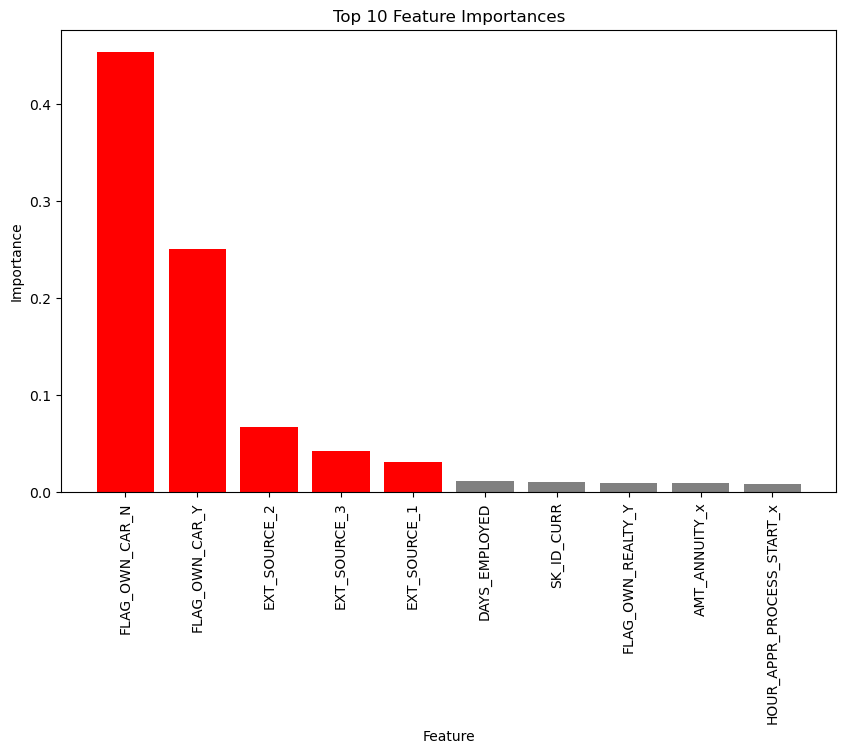

In [37]:
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
# Plotting the first 5 features in red
plt.bar(importance_df['Feature'][:5], importance_df['Importance'][:5], color='red')
# Plotting the second 5 features in gray
plt.bar(importance_df['Feature'][5:10], importance_df['Importance'][5:10], color='gray')
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Top 10 Feature Importances')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.show()

Here we can see what variables in the gradient boosting are the most valuable predictors overall. 

# 5 Results
<a id="section-5"></a>

After running our various models, we found gradient boosting to perform the best to predict whether an applicant should be approved or denied. Some of the most important features in our model included whether the applicant owned a car, the number of days before the application the person started their current employment, and whether or not the applicant owned real estate.

Another significant feature was their credit scores from outside entities. We understand that the purpose of this project is to determine whether applicants with little to no credit history should be approved for a loan or not but another significant feature was prior credit history. If an applicant does have at least some credit, it is beneficial and contributes to the decision on the application

We produced a Kaggle score of 0.65. This can definitely be improved in the future.

* Everytime I tried to "Jump to leaderboard position, it just refreshed the page and didnt do it, so I'm not sure what that is*

# Team Contributions

Kyle: Most of EDA, contributed on models

Hunter & RJ: Most of Modeling, contributed on EDA and results

Marcus: Interpretations & results, contributed well on models